# Libraries and functions

In [1]:
import PyPlot
const plt = PyPlot
using DelimitedFiles
using Printf
using LaTeXStrings
using Statistics
using SpecialFunctions
using Distributions
using LinearAlgebra
using Random
using WAV
using Distributions
using Einsum
using ExtractMacro

const SQRT05 = sqrt(0.5);
const SQRT2oPI = sqrt(2.0/pi);

ExpRange(ini,fin,bins) = unique(Int.(round.(exp.(LinRange(log(ini), log(fin), bins)))))
function ExpRange!(ini,fin,bins)
    res = []
    for i = bins:(2bins)
        res = unique(Int.(round.(exp.(LinRange(log(ini), log(fin), i)))))
        if length(res)==bins
            return res
        end
    end
    return res
end 

function println_matrix(A;STD=[])
    n,m = size(A);
    
    if length(STD)==0
        for i=1:n
            for j=1:m
                print(@sprintf("\t%.3f",A[i,j]))
            end
            println()
        end
    else
        for i=1:n
            for j=1:m
                print(@sprintf("\t%.3f (%.3f)",A[i,j],STD[i,j]))
            end
            println()
        end
    end
end
            


println_matrix (generic function with 1 method)

# Hierarchical RL

Given $\tilde{y}_t^* = sign\left(\sum^K_{k=1}V_k^*\nu_{k,t}\right)$, we update 
\begin{gather*}
\Delta W_k = \frac{\eta_1}{\sqrt{N}}\frac{1}{T}\sum_{t=1}^T{V_k\tilde{y_t} x_{t,k}} 
\\ 
\Delta V_k = \frac{\eta_2}N\frac1T\sum_{t=1}^T{\tilde{y_t}\frac{W_k \cdot x_{t,k}}{\sqrt{N}}}\textit{I}(\Phi),
\end{gather*}
where $\textit{I}(\Phi)=\theta(\tilde{y} == \hat{y})$.

In [348]:
mutable struct HRLTS_OP
    Q::Array{Float64, 2}
    R::Array{Float64, 2}
    S::Array{Float64, 2}
    V::Array{Float64, 1}
    VT::Array{Float64, 1}
end

mutable struct HRLTS_par
    η::Float64
    η2::Float64
    N::Int32
    T::Int32
    K::Int32
end

function HRLTS_dR(op,par)
    @extract op: Q R S V VT
    @extract par: η η2 N T K

    num = 0.0; denQ = 0.0;  denS = 0.0;
    for k=1:K
        num += V[k]*VT[k]*R[k,k]
        denQ += V[k]*V[k]*Q[k,k]
        denS += VT[k]*VT[k]*S[k,k]
    end
    P = 1-acos(num/sqrt(denQ*denS))/pi
    
    dR = η/sqrt(2pi)*((V*V').*R/sqrt(denQ) + (V*VT').*S/sqrt(denS))*P^(T-1)
    
    return dR/N
end

function HRLTS_dQ(op,par)
    @extract op: Q R S V VT
    @extract par: η η2 N T K

    num = 0.0; denQ = 0.0;  denS = 0.0;
    for k=1:K
        num += V[k]*VT[k]*R[k,k]
        denQ += V[k]*V[k]*Q[k,k]
        denS += VT[k]*VT[k]*S[k,k]
    end
    P = 1-acos(num/sqrt(denQ*denS))/pi
    
    dQ = 2η/sqrt(2pi)*((V*V').*Q/sqrt(denQ) + (V*VT').*R/sqrt(denS))*P^(T-1)
    dQ += (η*η)*(V*V')*P^T/T
    
    return dQ/N
end

function HRLTS_dV(op,par)
    @extract op: Q R S V VT
    @extract par: η η2 N T K

    num = 0.0; denQ = 0.0;  denS = 0.0;
    for k=1:K
        num += V[k]*VT[k]*R[k,k]
        denQ += V[k]*V[k]*Q[k,k]
        denS += VT[k]*VT[k]*S[k,k]
    end
    P = 1-acos(num/sqrt(denQ*denS))/pi
    
    dV = zeros(K)
    dV = η/sqrt(2pi)*(V.*diag(Q)/sqrt(denQ) + VT.*diag(R)/sqrt(denS))*P^(T-1)
    
    return dV/N
end

function HRLTS_loss(op,par)
    @extract op: Q R S V VT
    @extract par: K T
    
    num = 0.0; denQ = 0.0;  denS = 0.0;
    for k=1:K
        num += V[k]*VT[k]*R[k,k]
        denQ += V[k]*V[k]*Q[k,k]
        denS += VT[k]*VT[k]*S[k,k]
    end
    
    return acos(num/sqrt(denQ*denS))/pi
end


HRLTS_loss (generic function with 1 method)

## Simu

In [ ]:
ϕ, ϕprime = Linear, DLinear
N = 1000; 
epochs = 100000;
seeds = 5;
η = 3.0; η2 = 0.0;
Δ = 0.0;
K = 2;

T = 5;

batch = 1000;
epochs_print_n = 1000;
epochs_print = ExpRange!(1,epochs,epochs_print_n);
# epochs_print = 1:100:epochs+1

WT = randn(N,K); WT = sqrt(N)*WT/norm(WT)
VT = ones(K);

error_simu = zeros(length(epochs_print),seeds)
Q_simu = zeros(K,K,length(epochs_print),seeds)
R_simu = zeros(K,K,length(epochs_print),seeds)
V_simu = zeros(K,length(epochs_print),seeds)

W0 = randn(N,K); W0 = 0.001*W0/norm(W0)
V0 = 0.001*rand(K);
for seed = 1:seeds
    W = copy(W0); V = copy(V0); 

    epoch_print_idx = 1;
    test_x = randn(N,K,T,1000); test_y = zeros(T,1000);
    for t = 1:T
        for k = 1:K
            test_y[t,:] += (VT[k]*WT[:,k]'*test_x[:,k,t,:]/sqrt(N))[:];
        end
    end
    test_y = sign.(test_y)
    train_x = randn(N,K,T,batch); train_y = zeros(T,batch);
    for t = 1:T
        for k = 1:K
            train_y[t,:] += (VT[k]*WT[:,k]'*train_x[:,k,t,:]/sqrt(N))[:];
        end
    end
    train_y = sign.(train_y)
    
    λ = zeros(K,T)
    @time for epoch=1:epochs
        if epoch%batch == 0
            train_x = randn(N,K,T,batch); train_y = zeros(T,batch);
            for t = 1:T
                for k = 1:K
                    train_y[t,:] += (VT[k]*WT[:,k]'*train_x[:,k,t,:]/sqrt(N))[:];
                end
            end
            train_y = sign.(train_y)
        end
        if epoch == epochs_print[epoch_print_idx]
            Q_simu[:,:,epoch_print_idx,seed] = W'*W/N
            R_simu[:,:,epoch_print_idx,seed] = W'*WT/N
            V_simu[:,epoch_print_idx,seed] = copy(V)
            error_simu[epoch_print_idx,seed] = 0.0
            test_yhat = zeros(T,1000)
            V_simu[:,epoch_print_idx,seed] = copy(V)
            for t = 1:T
                for k = 1:K
                    test_yhat[t,:] += (V[k]*W[:,k]'*test_x[:,k,t,:]/sqrt(N))[:];
                end
            end
            test_yhat = sign.(test_yhat)
            error_simu[epoch_print_idx,seed] = 0.5 - 0.5mean(test_y.*test_yhat)
            epoch_print_idx += 1;
        end
        x = train_x[:,:,:,epoch%batch+1]; y = train_y[:,epoch%batch+1];
        for k=1:K
            λ[k,:] = x[:,k,:]'*W[:,k]/sqrt(N)
        end
        
        if all(sign.(λ'*V) .== y)
            for k=1:K
                W[:,k] = W[:,k] + η/sqrt(N)*x[:,k,:]*y*V[k]/T
            end
            V = V + η/N*(λ)*y/T
        end
    end
    
    println(error_simu[end,seed])
end

epochs_print = Array(epochs_print)[1:end-1]
error_simu_avg = mean(error_simu,dims=2)[:,1];
Q_simu_avg = mean(Q_simu,dims=4)[:,:,:,1];
R_simu_avg = mean(R_simu,dims=4)[:,:,:,1];
V_simu_avg = mean(V_simu,dims=3)[:,:,1];
error_simu_std = std(error_simu,dims=2)[:,1];
Q_simu_std = std(Q_simu,dims=4)[:,:,:,1];
R_simu_std = std(R_simu,dims=4)[:,:,:,1];
V_simu_std = std(V_simu,dims=3)[:,:,1];


 30.586475 seconds (9.77 M allocations: 109.718 GiB, 15.87% gc time)
0.322
 38.666034 seconds (9.77 M allocations: 109.707 GiB, 19.36% gc time)
0.3236
 34.384460 seconds (9.77 M allocations: 109.716 GiB, 21.27% gc time)
0.3176
 31.504156 seconds (9.77 M allocations: 109.707 GiB, 15.08% gc time)
0.3232
 34.568849 seconds (9.78 M allocations: 109.767 GiB, 20.41% gc time)
0.3154


final test error: 0.32036;


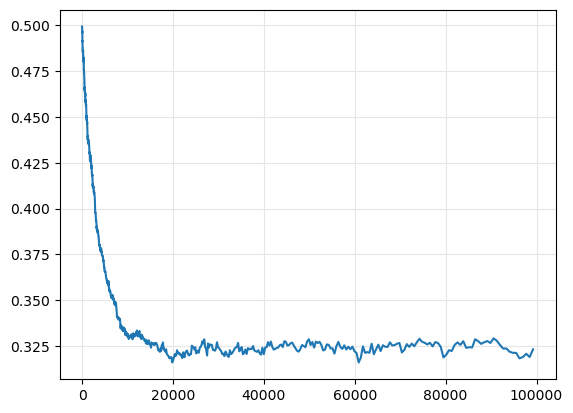

In [372]:
fig, ax = plt.subplots()
p = ax.plot(epochs_print,error_simu_avg[1:end-1])
# ax.set_yscale("log")
# ax.set_xscale("log")
ax.grid(c=[.9,.9,.9])
println("final test error: ", error_simu_avg[end], ";")


## ODE

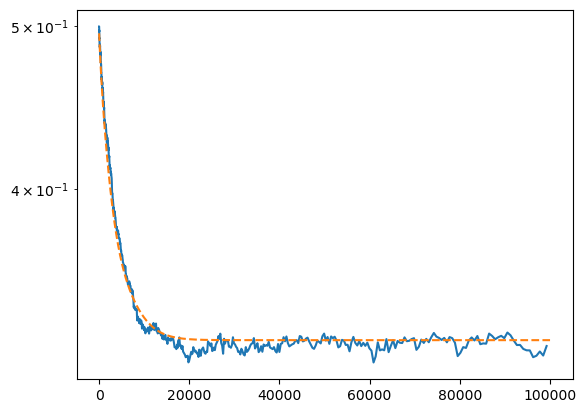

In [374]:
# WT = randn(N,KT);
# VT = randn(1,KT);
# W = randn(N,K); W = 0.001*W/norm(W)
# V = randn(1,K); V = 0.001*V/norm(V)

W = copy(W0);
Q = W'*W/N; R = W'*WT/N; S = WT'*WT/N; V = copy(V0);

op = HRLTS_OP(Q, R, S, vec(V), vec(VT))
par = HRLTS_par(η, η2, N, T, K)

Q_an = zeros(K,K,epochs); Q_an[:,:,1] = copy(op.Q);
R_an = zeros(K,K,epochs); R_an[:,:,1] = copy(op.R);
V_an = zeros(K,epochs); V_an[:,1] = copy(op.V);
loss = zeros(epochs); loss[1] = HRLTS_loss(op,par);
for epoch = 2:epochs
    # op.Q = copy(Q_simu_avg[:,:,epoch])
    # op.R = copy(R_simu_avg[:,:,epoch])
    # op.V = copy(V_simu_avg[:,epoch])
    
    dR = HRLTS_dR(op,par)
    dQ = HRLTS_dQ(op,par)
    dV = HRLTS_dV(op,par)
    
    Q = op.Q+dQ; R = op.R+dR; V = op.V+dV;
    op.Q = Q; op.R = R; op.V = V;
    Q_an[:,:,epoch] .= Q
    R_an[:,:,epoch] .= R
    V_an[:,epoch] .= V
    loss[epoch] = HRLTS_loss(op,par)
end

p = plt.plot(epochs_print,error_simu_avg[1:end-1])
# plt.fill_between(epochs_print,error_simu_avg-error_simu_std,error_simu_avg+error_simu_std,color=p[1].get_color(),alpha=0.3)
plt.plot(loss,ls="--")
plt.yscale("log")



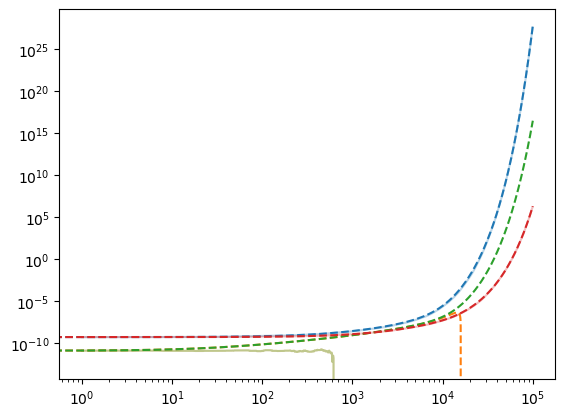

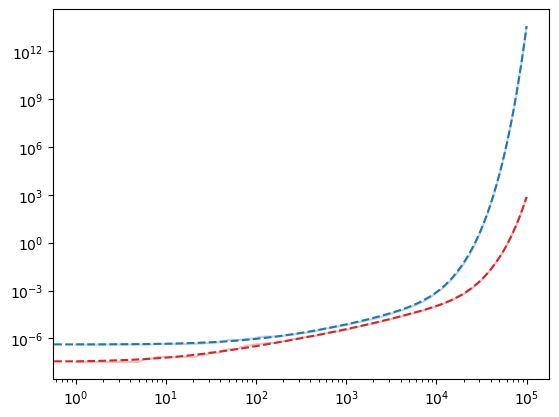

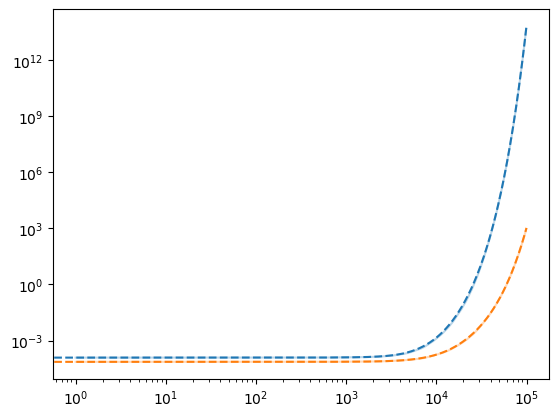

In [380]:
plt.figure()
for i=1:K
    for j=1:K
        p =plt.plot(epochs_print,Q_simu_avg[i,j,1:end-1],alpha=0.3)
        plt.plot(Q_an[i,j,:],ls="--",c=p[1].get_color())
    end
end
plt.yscale("log")
plt.xscale("log")

plt.figure()
for i=1:K
    for j=1:K
        p =plt.plot(epochs_print,R_simu_avg[i,j,1:end-1],alpha=0.3)
        plt.plot(R_an[i,j,:],ls="--",c=p[1].get_color())
    end
end
plt.yscale("log")
plt.xscale("log")

plt.figure()
for i=1:K
    p =plt.plot(epochs_print,V_simu_avg[i,1:end-1],alpha=0.3)
    plt.plot(V_an[i,:],ls="--",c=p[1].get_color())
end
plt.yscale("log")
plt.xscale("log")
